In [100]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
import warnings
warnings.filterwarnings("ignore")
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *
from nltk.stem import *
import nltk
nltk.download('wordnet')

In [2]:
#Para listar los archivos de directorios
from os import listdir
mypath = "C:/Users/ivandario.gomez/Documents/Varios IDGR/GitUniandes/Uniandes/Comunicados/"
files = listdir(mypath)

#cargar textos en un vector
docVector = []
for i in range(len(files)):
    file = open(mypath + files[i],"r", encoding="utf8") 
    #print(file.read())
    docVector.append({'text': file.read(), 'Date': files[i][:7]})

In [3]:
#cargar textos en un dataframe
docDataF = pd.DataFrame(docVector)
docDataF.head()

,Date,text
0,2007-06,La Junta Directiva del Banco de la República e...
1,2007-07,La Junta Directiva del Banco de la República e...
2,2007-08,La Junta Directiva del Banco de la República e...
3,2007-09,La Junta Directiva del Banco de la República e...
4,2007-10,La Junta Directiva del Banco de la República e...


In [4]:
#cargar IP en un dataframe
ipc = pd.read_excel(open('inflación.xlsx', 'rb'),sheet_name='ipc')
ipc.head()

,ANIO_MES,IPC
0,2007-06,0.056114
1,2007-07,0.053881
2,2007-08,0.051937
3,2007-09,0.049796
4,2007-10,0.052569


In [5]:
#Unir los textos y la serie de tiempo en un solo dataframe
data = ipc.set_index('ANIO_MES').join(docDataF.set_index('Date'))
data['IPC'] = data.IPC * 100
data.head()

,IPC,text
ANIO_MES,,
2007-06,5.611418,La Junta Directiva del Banco de la República e...
2007-07,5.388066,La Junta Directiva del Banco de la República e...
2007-08,5.193734,La Junta Directiva del Banco de la República e...
2007-09,4.979589,La Junta Directiva del Banco de la República e...
2007-10,5.256945,La Junta Directiva del Banco de la República e...


# Radom Forest for predict IPC

In [6]:
#Text: será preprocesaro para generar las features
#IPC: Variables a predecir
X = data['text']
y = data['IPC']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
#Calculate vectorizer and print the words
vect = CountVectorizer()
X_dtm_train = vect.fit_transform(X_train)
print(vect.get_feature_names())

['000', '02', '06', '07', '10', '100', '11', '12', '13', '14', '15', '15948', '16', '17', '18', '19', '1995', '1997', '1pp', '20', '200', '2000', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '21', '22', '23', '24', '25', '2500', '25pb', '27', '28', '29', '30', '300', '3000', '31', '33', '34', '35', '36', '38', '381', '39', '40', '41', '42', '43', '44', '45', '46', '47', '50', '500', '52', '53', '54', '55', '550', '56', '57', '58', '59', '63', '64', '65', '66', '668', '67', '69', '700', '72', '73', '74', '75', '750', '76', '77', '79', '81', '82', '84', '86', '87', '89', '92', '925', '98', 'abajo', 'abarcando', 'abierta', 'abril', 'abundancia', 'acceso', 'accionarios', 'acciones', 'acción', 'aceleración', 'acelerado', 'acelere', 'acelerándose', 'aceleró', 'acentuada', 'acentuado', 'acentuados', 'acentuarse', 'acercaron', 'acercarse', 'acercará', 'acontecimientos', 'acordó', 'acreedores', 'activación', 'activado', 'activas', 'actividad', 

In [8]:
X_dtm_train.toarray().shape

(73, 2203)

In [9]:
# Use Random Forest to predict the IPC
rfc = RandomForestRegressor(random_state=42, n_jobs=-1) 
pd.Series(cross_val_score(rfc, X_dtm_train, y_train, cv=10, scoring='neg_mean_squared_error')).describe()

count    10.000000
mean     -1.134656
std       0.577831
min      -2.028126
25%      -1.505558
50%      -1.019938
75%      -0.733687
max      -0.286566
dtype: float64

Text(0, 0.5, 'NEG_RMSE')

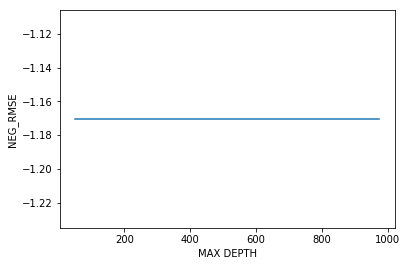

In [10]:
max_depth_range = range(50, 1000, 25)
RMSE_scores_featu = []

for depth in max_depth_range:
    rfc = RandomForestRegressor(max_depth=depth, random_state=42, n_jobs=-1) 
    RMSE_scores_featu.append(cross_val_score(rfc, X_dtm_train, y_train, cv=4, scoring='neg_mean_squared_error').mean())

#best_maxfeatures = feature_range[RMSE_scores_featu.index(max(RMSE_scores_featu))]
#print ("best_maxfeatures: ", best_maxfeatures)
plt.plot(max_depth_range, RMSE_scores_featu)
plt.xlabel('MAX DEPTH')
plt.ylabel('NEG_RMSE')

# Latent Dirichlet Allocation (LDA)

In [96]:
#revisar esta función porque genera error con la librería de "stem" esta comentariada adentro de la función preprocess
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


# Write a function to perform lemmatize and stem preprocessing steps on the data set.
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            print(token)
            token2 = result.append(lemmatize_stemming(token))
            print(token2)
            result.append(token)
    return result

documents = []
#Select a document to preview after preprocessing
for texto in data.text[:2]:
    documents.append(preprocess(texto))
    
dictionary = gensim.corpora.Dictionary(documents)

#Filter out tokens that appear in
#less than 15 documents (absolute number) or
#more than 0.5 documents (fraction of total corpus size, not absolute number).
#after the above two steps, keep only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

junta
None
directiva
None
banco
None
república
None
sesión
None
decidió
None
aumentar
None
tasas
None
interés
None
intervención
None
esta
None
forma
None
tasa
None
base
None
para
None
subastas
None
expansión
None
pasará
None
inflación
None
consumidor
None
mayo
None
dejó
None
subir
None
espera
None
disminuya
None
segundo
None
semestre
None
embargo
None
ritmo
None
anual
None
crecimiento
None
precios
None
mantiene
None
encima
None
metas
None
establecidas
None
banco
None
información
None
disponible
None
sugiere
None
crecimiento
None
demanda
None
agregada
None
continúa
None
ritmo
None
acelerado
None
incluso
None
superior
None
proyecciones
None
previas
None
junta
None
reiteró
None
compromiso
None
mantener
None
política
None
monetaria
None
coherente
None
meta
None
inflación
None
fijada
None
para
None
rango
None
garantice
None
convergencia
None
inflación
None
hacia
None
meta
None
largo
None
plazo
None
punto
None
porcentual
None
esta
None
política
None
contribuye
None
mantener
None
crecimiento


In [101]:
from es_lemmatizer import lemmatize
import spacy
nlp = spacy.load("es")
nlp.add_pipe(lemmatize, after="tagger")

OSError: [E050] Can't find model 'es'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [89]:
dictionary.token2id
len(dictionary)

325

## Running LDA using Bag of Words

In [14]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [15]:
#For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"segundo" + 0.011*"nivel" + 0.011*"punto" + 0.009*"semestre" + 0.009*"estabilidad" + 0.008*"deuda" + 0.008*"emergentes" + 0.008*"ritmo" + 0.008*"mantienen" + 0.008*"menores"
Topic: 1 
Words: 0.012*"menos" + 0.011*"confianza" + 0.011*"ritmo" + 0.010*"hogares" + 0.009*"siguiente" + 0.009*"pero" + 0.009*"primer" + 0.008*"europa" + 0.008*"colombiana" + 0.008*"tanto"
Topic: 2 
Words: 0.014*"continúa" + 0.010*"riesgos" + 0.010*"riesgo" + 0.010*"petróleo" + 0.010*"altos" + 0.008*"país" + 0.008*"inversión" + 0.008*"confianza" + 0.008*"exportaciones" + 0.008*"emergentes"
Topic: 3 
Words: 0.018*"caída" + 0.016*"muestran" + 0.011*"expansiva" + 0.011*"tendencia" + 0.011*"excluye" + 0.011*"confianza" + 0.010*"volátiles" + 0.010*"también" + 0.010*"aquella" + 0.010*"obstante"
Topic: 4 
Words: 0.013*"capacidad" + 0.012*"riesgo" + 0.011*"agregada" + 0.011*"metas" + 0.011*"coherente" + 0.010*"desaceleración" + 0.010*"consideró" + 0.009*"recuperación" + 0.009*"mantienen" + 0.009*"n

## Running LDA using TF-IDF

In [16]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [17]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.011*"choques" + 0.010*"niño" + 0.008*"mecanismos" + 0.008*"fenómeno" + 0.008*"estos" + 0.008*"cifras" + 0.008*"años" + 0.008*"primer" + 0.007*"esto" + 0.007*"devaluación"
Topic: 1 Word: 0.012*"cayendo" + 0.008*"disminución" + 0.008*"fijado" + 0.008*"menores" + 0.008*"enero" + 0.008*"recuperación" + 0.007*"resultado" + 0.007*"futura" + 0.007*"reducir" + 0.007*"confianza"
Topic: 2 Word: 0.012*"compras" + 0.009*"postura" + 0.009*"empleo" + 0.009*"septiembre" + 0.009*"medio" + 0.009*"estable" + 0.008*"menos" + 0.008*"hasta" + 0.008*"mitad" + 0.008*"cartera"
Topic: 3 Word: 0.010*"cartera" + 0.009*"atrás" + 0.009*"especial" + 0.009*"meses" + 0.008*"externo" + 0.008*"millones" + 0.008*"comercial" + 0.008*"reservas" + 0.008*"julio" + 0.007*"incertidumbre"
Topic: 4 Word: 0.009*"muestra" + 0.009*"continúe" + 0.009*"incremento" + 0.008*"regulados" + 0.008*"también" + 0.008*"transables" + 0.008*"aumentos" + 0.008*"tendencia" + 0.008*"mayoría" + 0.008*"diciembre"
Topic: 5 Word: 0.0

In [20]:
#Performance evaluation by classifying sample document using LDA Bag of Words model
for index, score in sorted(lda_model[bow_corpus], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

IndexError: list index out of range

In [53]:
#Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model_tfidf[bow_corpus], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

IndexError: list index out of range

In [54]:
#Testing model on unseen document
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5499550700187683	 Topic: 0.021*"caída" + 0.018*"punto" + 0.015*"cayendo" + 0.015*"porcentual" + 0.013*"será"
Score: 0.0500195249915123	 Topic: 0.015*"recuperación" + 0.011*"menos" + 0.010*"debajo" + 0.010*"segundo" + 0.010*"aumento"
Score: 0.050006162375211716	 Topic: 0.012*"nivel" + 0.011*"punto" + 0.011*"producto" + 0.010*"emergentes" + 0.009*"medio"
Score: 0.050004731863737106	 Topic: 0.011*"inversión" + 0.010*"europa" + 0.010*"siguiente" + 0.010*"riesgo" + 0.010*"inalterada"
Score: 0.05000365898013115	 Topic: 0.017*"peso" + 0.012*"mismo" + 0.012*"atrás" + 0.011*"petróleo" + 0.011*"incremento"
Score: 0.05000358819961548	 Topic: 0.014*"ingreso" + 0.011*"país" + 0.011*"riesgo" + 0.011*"nacional" + 0.011*"desaceleración"
Score: 0.05000203102827072	 Topic: 0.017*"caída" + 0.014*"país" + 0.012*"liquidez" + 0.011*"reducir" + 0.011*"productiva"
Score: 0.050001904368400574	 Topic: 0.013*"país" + 0.013*"continúa" + 0.011*"petróleo" + 0.010*"riesgo" + 0.010*"incremento"
Score: 0.0500